In [34]:
import datasets
from functools import reduce
from collections import Counter

dataset = datasets.load_dataset('lecslab/ddo-igt')

def split_glosses(row):
    word_glosses = row['glosses'].split()
    glosses = [word.split("-") for word in word_glosses]
    glosses = reduce(lambda a,b:a+["[SEP]"]+b, glosses)
    glosses = [gloss if gloss.isupper() else "STEM" for gloss in glosses]
    row['glosses_split'] = [gloss for gloss in glosses if gloss != '']
    return row

dataset = dataset.map(split_glosses)

all_glosses = Counter()
for row in dataset['train']['glosses_split']:
    all_glosses.update(row)
# all_glosses = sorted(all_glosses)
# print(len(all_glosses))
print(all_glosses)

Counter({'STEM': 69242, '[SEP]': 67800, 'PFV.CVB': 6654, 'PST.UNW': 5448, 'TOP': 4660, 'ERG': 4422, 'III': 4260, 'QUOT': 3542, 'IV': 3284, 'GEN1': 2498, 'II': 2462, 'LAT': 2276, 'PL': 1562, 'DEM1.IISG.OBL': 1436, 'DEM1.ISG.OBL': 1390, 'I.PL': 1378, 'DEF': 1340, 'PST.PRT': 1258, 'DEM1.SG': 1226, 'GEN2': 1216, 'POSS.ESS': 1172, 'EMPH': 1160, 'SUPER.ESS': 1160, 'AD.ESS': 1106, 'IPFV.CVB': 1094, 'ANT.CVB': 1026, 'INF': 974, 'CONT.ESS': 912, 'CNTR': 880, 'RES.PRT': 810, 'POSS.LAT': 796, 'MSD': 682, 'DEM2.ISG.OBL': 648, 'PST.WIT': 580, 'SUPER.LAT': 552, 'PRS': 510, 'IN.ESS': 506, 'III.PL': 492, 'ATTR': 492, 'AD.LAT': 480, 'DEM2.ISG': 462, 'CND.CVB': 426, 'IN.ABL': 406, 'SIM.CVB': 390, 'DEM1.IPL.OBL': 380, 'NEG': 366, 'FUT.DEF': 352, 'IMPR': 338, 'PRS.PRT': 334, 'DEM2.IISG.OBL': 330, 'DEM2.IISG': 326, 'IN.VERS': 326, 'DEM1.IPL': 306, 'Q': 286, 'CAUS': 286, 'CONT.ABL': 282, 'NEG.PST.CVB': 282, 'CSL.CVB': 276, 'SUPER.ABL': 274, 'ATTR.OBL': 260, 'APUD.ESS': 260, 'APUD.LAT': 238, 'DISTR': 238, 'I

In [3]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=dataset['train']['glosses_split'], window=3, vector_size=1000, min_count=3)

In [4]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objs as go

def reduce_dimensions(model):
    num_components = 2  # number of dimensions to keep after compression

    # extract vocabulary from model and vectors in order to associate them in the graph
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # apply TSNE
    tsne = TSNE(n_components=num_components, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y1_vals = [v[1] for v in vectors]
    return x_vals, y1_vals, labels, tsne


def plot_embeddings(x_vals, y1_vals, labels):
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y1_vals,  mode='text', text=labels)
    fig.add_trace(trace)
    fig.update_layout(title="Morph2vec TSNE")
    fig.show()
    return fig


x_vals, y1_vals, labels, tsne = reduce_dimensions(model)

plot = plot_embeddings(x_vals, y1_vals, labels)

In [35]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from typing import List

class SVDModel:
    def __init__(self, embeddings: np.array, glosses: List[str]):
        self.embeddings = embeddings
        self.glosses = glosses
    
    def get_vector(self, gloss):
        gloss_index = self.glosses.index(gloss)
        return self.embeddings[gloss_index]

def svd(all_glosses, sentences, window, vector_size):
    # Compute the co-occurrance matrix
    cooccurrance = np.zeros((len(all_glosses), len(all_glosses)), dtype=np.int64)
    for sentence in sentences:
        for i in range(len(sentence)):
            center_gloss_index = all_glosses.index(sentence[i])
            for j in range(max(i - window, 0), min(i + window + 1, len(sentence))):
                if i == j:
                    continue
                context_gloss_index = all_glosses.index(sentence[j])
                cooccurrance[center_gloss_index][context_gloss_index] += 1
    
    cooccurrance = pd.DataFrame(data=cooccurrance, index=all_glosses, columns=all_glosses)
    
    # Convert to PPMI
    col_totals = cooccurrance.sum(axis=0)
    total = col_totals.sum()
    row_totals = cooccurrance.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    ppmi = cooccurrance / expected
    # Silence distracting warnings about log(0):
    with np.errstate(divide='ignore'):
        ppmi = np.log(ppmi)
    ppmi[np.isinf(ppmi)] = 0.0 
    ppmi[ppmi < 0] = 0.0
    
    # Perform SVD
    svd = TruncatedSVD(n_components=vector_size)
    embeddings = svd.fit_transform(ppmi.to_numpy())
    return SVDModel(embeddings=embeddings, glosses=all_glo sses)
    
svd(sorted(all_glosses), sentences=dataset['train']['glosses_split'], window=3, vector_size=4).embeddings

array([[ 2.44406424e+00, -5.61202110e-01,  9.31297028e-01,
        -8.82881004e-01],
       [ 4.61575242e-01, -1.20946120e-01,  3.47358688e-01,
         2.50518431e-01],
       [ 1.67263599e+00, -5.63269988e-02,  2.02384584e-01,
        -6.11445929e-01],
       [ 2.29442357e+00,  1.25119754e-01,  1.04559015e+00,
        -2.62107048e-01],
       [ 2.24736947e+00, -1.13561494e+00,  1.32252911e+00,
        -2.39630358e-02],
       [ 1.17532256e+00, -4.33017378e-01,  2.48761965e-01,
        -2.23826028e-01],
       [ 2.40848383e+00, -1.75915017e+00, -5.47552233e-01,
        -1.19892205e+00],
       [ 1.69148369e+00, -7.93968406e-01, -6.75991823e-01,
        -5.09273800e-01],
       [ 2.54214086e+00, -1.23803096e+00, -1.47886582e+00,
        -8.18675289e-01],
       [ 3.94038295e-01, -1.61222805e-01,  2.92609438e-01,
         1.85851777e-01],
       [ 2.36050110e+00, -1.23408010e+00, -1.60489101e+00,
        -6.22070461e-01],
       [ 1.34511894e+00, -6.98311376e-01, -2.41708948e-01,
      

In [42]:
import itertools
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
import random 
from src import features

# Compute metrics over various hyperparams
glosses_sorted = sorted(all_glosses)

ling_vectors, _ = features.create_feature_map('./ddo_features_v1.csv', sorted(all_glosses))
ling_vectors = {
    gloss: vector[1:] for gloss, vector in zip(glosses_sorted, ling_vectors) if all_glosses[gloss] >= 5 and vector[0] == 2
}

print(ling_vectors)

{'AD.ABL': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'AD.ESS': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'AD.LAT': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'AD.VERS': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 'AD.VERS.DIST': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 'ANT.CVB': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [46]:
def cos_sim(a, b):
    return dot(a, b)/(norm(a)*norm(b))

def compute_sim_correlation(m, model_type):
    gloss_combos = []
    ling_similarity = []
    embed_similarity = []
    random_similarity = []
    
    for gloss1, gloss2 in itertools.combinations(ling_vectors.keys(), 2):
        if gloss1 == gloss2:
            continue

        sim = cos_sim(np.array(ling_vectors[gloss1]), np.array(ling_vectors[gloss2]))
        if sim == 0:
            # orthogonal
            continue
    
        gloss_combos.append(f"{gloss1}, {gloss2}")
        ling_similarity.append(sim)

        if model_type == 'w2v':
            embed_similarity.append(cos_sim(m.wv.get_vector(gloss1), m.wv.get_vector(gloss2)))
        else:
            embed_similarity.append(cos_sim(m.get_vector(gloss1), m.get_vector(gloss2)))

        # Get a random gloss and compute similarity
        random_gloss = random.sample([gloss for gloss in ling_vectors.keys() if gloss != gloss1], 1)[0]
        if model_type == 'w2v':
            random_similarity.append(cos_sim(m.wv.get_vector(gloss1), m.wv.get_vector(random_gloss)))
        else:
            random_similarity.append(cos_sim(m.get_vector(gloss1), m.get_vector(random_gloss)))
    
    true_sim = np.corrcoef(np.array(ling_similarity), np.array(embed_similarity))[0, 1]
    random_sim = np.corrcoef(np.array(ling_similarity), np.array(random_similarity))[0, 1]
    return true_sim, random_sim

w2v_corrs = np.zeros((51, 11))
w2v_corrs_random = np.zeros((51, 11))
w2v_most_similar = defaultdict(lambda: defaultdict(int))

w2v_sg_corrs = np.zeros((51, 11))
w2v_sg_corrs_random = np.zeros((51, 11))
w2v_sg_most_similar = defaultdict(lambda: defaultdict(int))

svd_corrs = np.zeros((51, 11))
svd_corrs_random = np.zeros((51, 11))
svd_most_similar = defaultdict(lambda: defaultdict(int))

for size in tqdm(range(5, 51)):
    for window in range(1, 11):
        # Word2vec
        w2v_model = Word2Vec(sentences=dataset['train']['glosses_split'], window=window, vector_size=size, min_count=5)
        w2v_corrs[size][window], w2v_corrs_random[size][window] = compute_sim_correlation(w2v_model, 'w2v')
        for gloss in w2v_model.wv.key_to_index.keys():
            w2v_most_similar[gloss][w2v_model.wv.most_similar(gloss)[0][0]] += 1

        # Word2vec skip gram
        w2v_sg_model = Word2Vec(sentences=dataset['train']['glosses_split'], window=window, vector_size=size, sg=1, min_count=5)
        w2v_sg_corrs[size][window], w2v_sg_corrs_random[size][window] = compute_sim_correlation(w2v_sg_model, 'w2v')
        for gloss in w2v_sg_model.wv.key_to_index.keys():
            w2v_sg_most_similar[gloss][w2v_sg_model.wv.most_similar(gloss)[0][0]] += 1

        # SVD
        svd_model = svd(glosses_sorted, dataset['train']['glosses_split'], window=window, vector_size=size)
        svd_corrs[size][window], svd_corrs_random[size][window] = compute_sim_correlation(svd_model, 'svd')
        for gloss1 in svd_model.glosses:
            smallest_dist = None
            closest_gloss = None
            # Compute most similar
            for gloss2 in svd_model.glosses:
                dist = cos_sim(svd_model.get_vector(gloss1), svd_model.get_vector(gloss2))
                if smallest_dist is None or dist < smallest_dist:
                    closest_gloss = gloss2
                    smallest_dist = dist

            svd_most_similar[gloss1][closest_gloss] += 1



  0%|          | 0/46 [00:00<?, ?it/s]

In [44]:
svd_corrs

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.18135184, 0.23690586, 0.16389187, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.20021703, 0.2477833 , 0.19991108, 0.

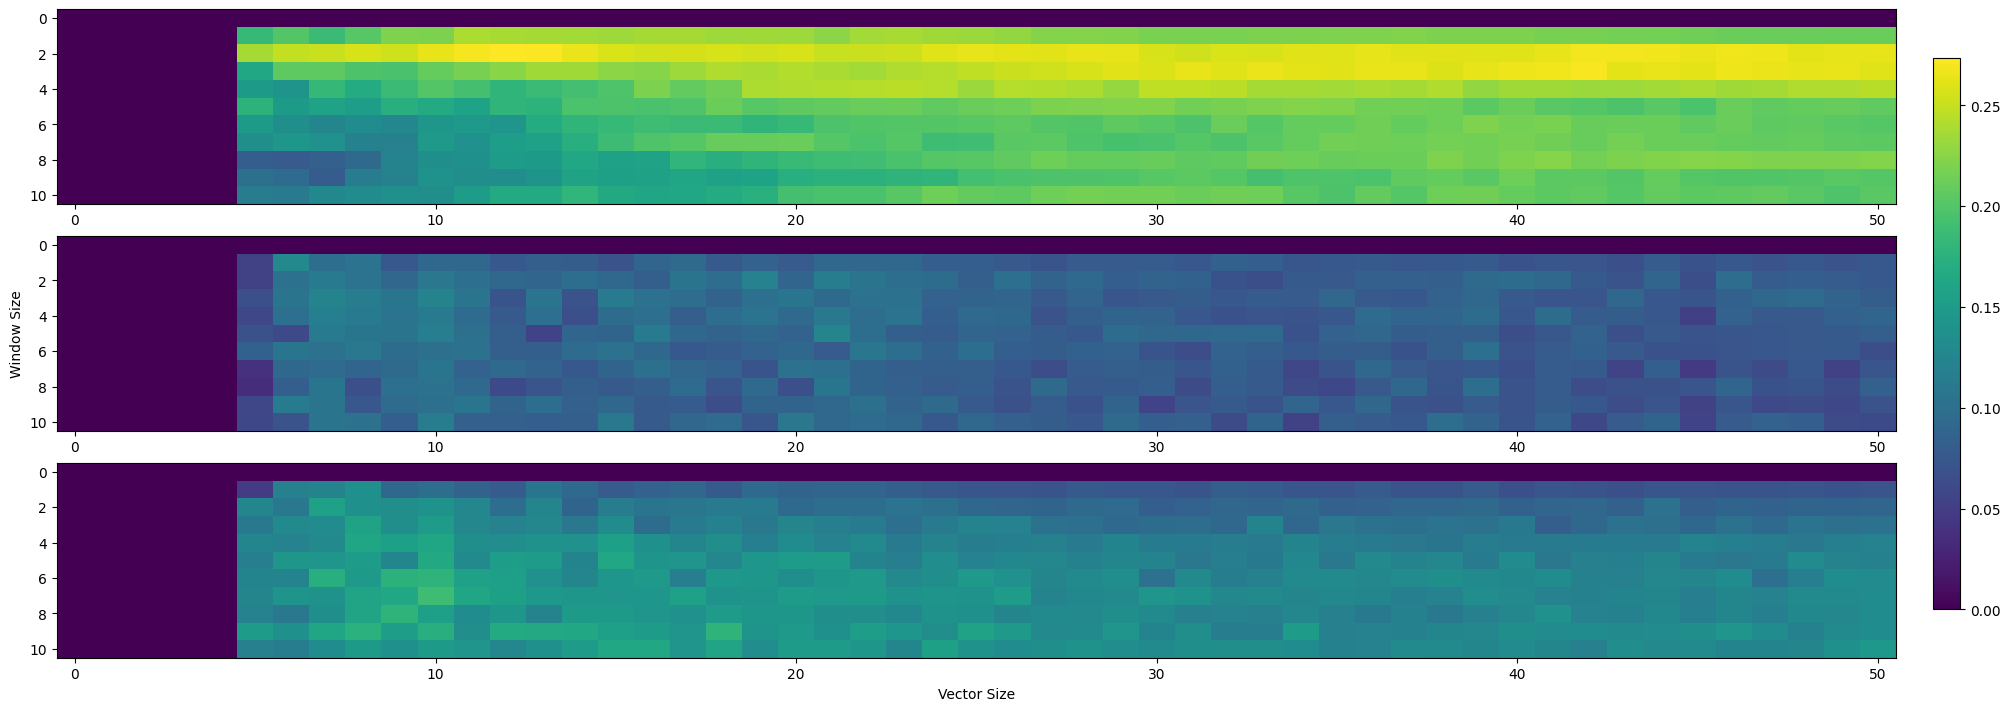

In [50]:
import numpy as np

# Assuming svd_corrs, w2v_corrs, and w2v_sg_corrs are your datasets
datasets = [svd_corrs, w2v_corrs, w2v_sg_corrs]

# Determine the global min and max
global_min = min([np.min(data) for data in datasets])
global_max = max([np.max(data) for data in datasets])

# Create a single figure for all subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 7), constrained_layout=True)

# Plot each heatmap with the same vmin and vmax
for i, data in enumerate(datasets):
    im = axs[i].imshow(data.transpose(), cmap='viridis', aspect='auto', vmin=global_min, vmax=global_max)
    if i == len(datasets) - 1:
        # Add x-axis label to the bottom subplot
        axs[i].set_xlabel('Vector Size')
    if i == 1:
        # Add y-axis label to the left side, applying to all since they share the context
        axs[i].set_ylabel('Window Size')

# Create a color bar for the last image plotted, with its size based on the figure
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', fraction=0.015, pad=0.02)

plt.show()

# Save the figure with the color bar
fig.savefig('results/ddo-heatmaps.pdf', bbox_inches='tight', transparent=True)

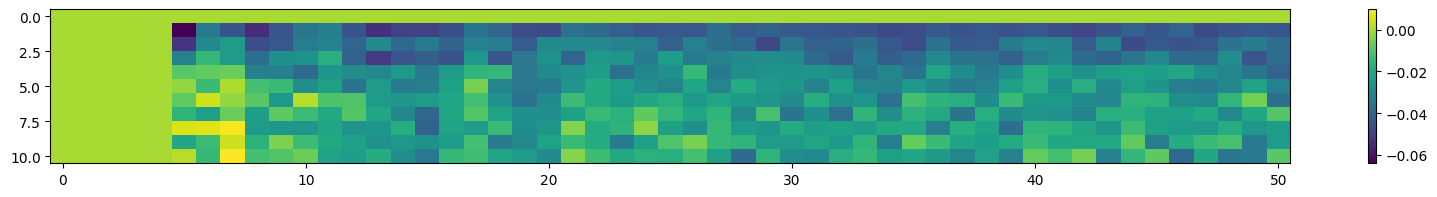

In [16]:
plt.figure(figsize = (20,2))
plt.imshow(w2v_corrs.transpose(), cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()

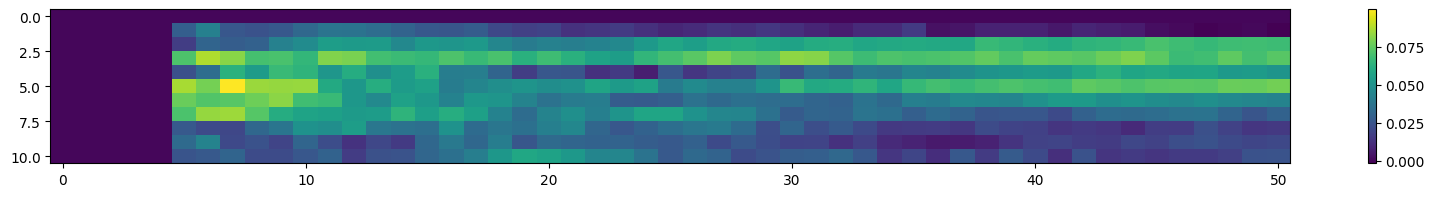

In [15]:
plt.figure(figsize = (20,2))
plt.imshow(svd_corrs.transpose(), cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()

In [48]:
def summary(corrs):
    print("Mean", np.mean(corrs[corrs != 0]))
    print("Std", np.std(corrs[corrs != 0]))
    print("Median", np.median(corrs[corrs != 0]))
    print("Min", np.min(corrs[corrs != 0]))
    print("Max", np.max(corrs[corrs != 0]))

print('SVD')
summary(svd_corrs)
print()
summary(svd_corrs_random)
print('\nCBOW')
summary(w2v_corrs)
print()
summary(w2v_corrs_random)
print('\nSkip-gram')
summary(w2v_sg_corrs)
print()
summary(w2v_sg_corrs_random)
print()


SVD
Mean 0.20853960389808787
Std 0.037467727249774506
Median 0.21059854358794267
Min 0.07877701225615137
Max 0.2736869244255322

Mean 0.01835733212028604
Std 0.03355261501230272
Median 0.019818824162393892
Min -0.09708957025316622
Max 0.10045820173594414

CBOW
Mean 0.08374212743111764
Std 0.01434725108316045
Median 0.08272532294710633
Min 0.0353473554355011
Max 0.12916865888499768

Mean -0.04109527773976176
Std 0.03223404940908058
Median -0.040796087180848206
Min -0.13970391299360052
Max 0.08189936740193353

Skip-gram
Mean 0.1224602020372742
Std 0.023624617097647238
Median 0.12512885898691742
Min 0.04815054371525329
Max 0.1883644270748752

Mean -0.042513013554743025
Std 0.03164707424616271
Median -0.04142570940356193
Min -0.1286897025531945
Max 0.06355412672642241



In [56]:
w2v_sg_most_similar

defaultdict(<function __main__.<lambda>()>,
            {'STEM': defaultdict(int,
                         {'DEM4.ISG.OBL': 7,
                          'POSS.ABL.DIST': 33,
                          '[SEP]': 144,
                          'LCV.CVB': 1,
                          'PST.UNW': 1,
                          'CONT.ABL.DIST': 22,
                          'CONT.VERS.DIST': 3,
                          'PURP.CVB': 3,
                          'APUD.ABL': 1,
                          'INTS': 2,
                          'RES.PRT.OBL': 71,
                          'EQU1': 1,
                          'LOC.ORIG': 86,
                          'DEM3.IISG.OBL': 10,
                          'NEG.PRS.PRT.OBL': 8,
                          'APUD.VERS.DIST': 21,
                          'DEM3.SG': 4,
                          'CND': 12,
                          'SUPER.ABL.DIST': 1,
                          'ZA': 2,
                          'IN.LAT.DIST': 13,
                      

In [60]:
for gloss in sorted(svd_most_similar):
    if len(svd_most_similar[gloss]) == 0:
        continue
    top_key = max(svd_most_similar[gloss], key=svd_most_similar[gloss].get)
    prob = svd_most_similar[gloss][top_key] / 500
    print(f"{gloss}: {top_key} {prob}")

AD.ABL: PSTUNW 0.138
AD.ABL.DIST: FUT.DEF 0.142
AD.ESS: IRR 0.09
AD.LAT: COND.IRR 0.174
AD.VERS: POSS.ESS.DIST(?) 0.124
AD.VERS.DIST: PROHIB 0.098
ADV: SUPER.ABL.DIST 0.116
ANT.CVB: COND.IRR 0.168
APUD.ABL: DEM2.IIPL 0.102
APUD.ABL.DIST: CNTR 0.088
APUD.ESS: LNK 0.122
APUD.LAT: APUD.ABL.DIST 0.106
APUD.VERS: PSTUNW 0.116
APUD.VERS.DIST: SUPER.LAT.DIST 0.112
ATTR: NEG.PRSPRT.OBL 0.138
ATTR.OBL: SUPER.ESS.DIST 0.2
CAUS: GER.PURP 0.124
CNC.CVB: DEM2.IIPL 0.182
CND: SUPER.LAT.DIST 0.096
CND.CVB: DIST 0.08
CND.CVB.IRR: SUPER.LAT.DIST 0.066
CNDCVB: SUPER.LAT.DIST 0.132
CNTR: APUD.ABL.DIST 0.13
COND: SUPER.LAT.DIST 0.168
COND.IRR: SUPER.LAT.DIST 0.132
CONT.ABL: GER.PURP 0.206
CONT.ABL.DIST: EQU1 0.122
CONT.ESS: SUPER.ESS.DIST 0.17
CONT.ESS.DIST: QUOT 0.094
CONT.LAT: CNDCVB 0.134
CONT.VERS: NEG.PRSPRT 0.138
CONT.VERS.DIST: SUPER.LAT.DIST 0.178
CSL.CVB: IN.VERS.DIST 0.094
DEF: SUPER.ESS.DIST 0.176
DEF1.IISG: FUT.CVB 0.116
DEM1.IIPL: CNDCVB 0.094
DEM1.IIPL.OBL: VOC 0.154
DEM1.IISG.OBL: NEG.PSTUN

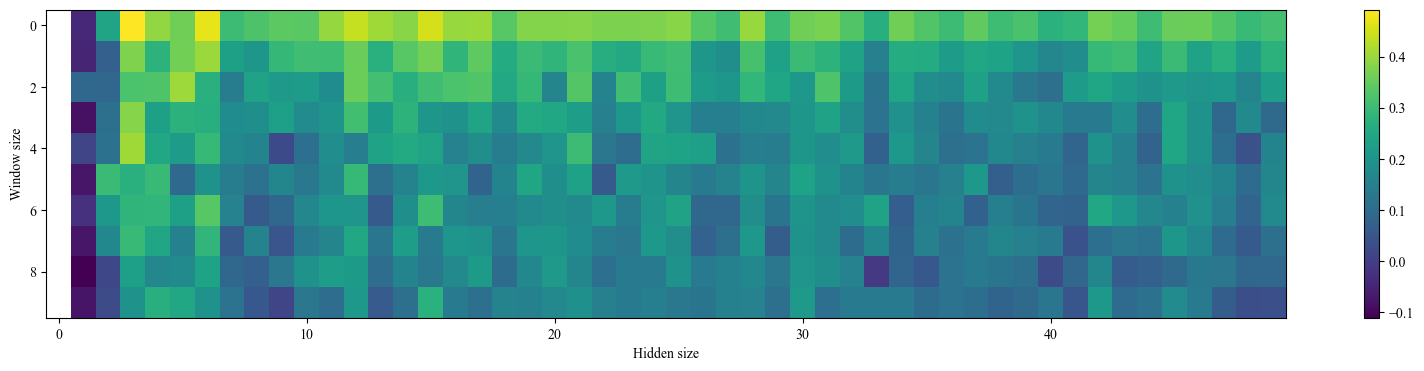

In [72]:
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize = (20,4))
plt.imshow(corrs.transpose(), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel("Hidden size")
plt.ylabel("Window size")

# plt.show()
# plt.show()
plt.savefig("usp_w2v.eps")

Best k is 8 with silhouette score 0.2646358013153076


defaultdict(<function __main__.<lambda>()>,
            {5: ['[SEP]'],
             6: ['S', 'NUM', 'ART', 'DIM', 'EXS'],
             2: ['ADV',
              'PART',
              'DEM',
              'PRON',
              '???',
              'CONJ',
              'NEG',
              'VOC',
              'INT',
              'ITS',
              'AFI'],
             3: ['VT', 'VI', 'E1S', 'DIR', 'E2S', 'A1S', 'AP', 'PAS'],
             4: ['E3S', 'E1P', 'E3'],
             7: ['INC',
              'COM',
              'PL',
              'SC',
              'MOV',
              'TAM',
              'A2S',
              'AGT',
              'POS',
              'ITR',
              'IMP',
              'MED',
              'INS',
              'CAU'],
             1: ['SREL', 'PREP', 'ADJ', 'NOM', 'CLAS'],
             0: ['ENF',
              'SAB',
              'PP',
              'AFE',
              'A1P',
              'TOP',
              'SV',
              'COND',
         

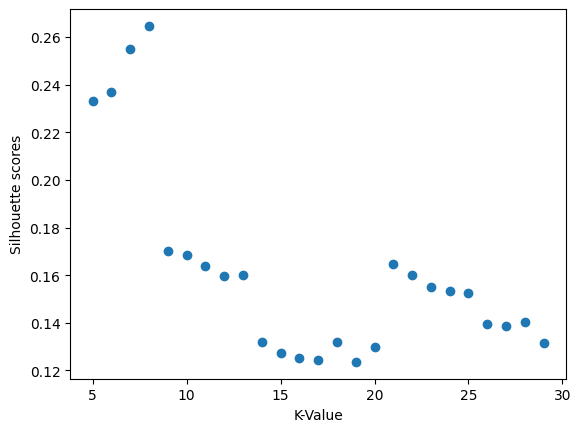

In [34]:
from sklearn.cluster import KMeans
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
import random

random.seed(0)

model = Word2Vec(sentences=dataset['train']['glosses_split'], window=3)
silhouette_scores = []

for k in range(5, 30):
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(model.wv.vectors)
    silhouette_scores.append(silhouette_score(model.wv.vectors, labels))

    
plt.scatter(range(5, 30), silhouette_scores)
plt.xlabel('K-Value')
plt.ylabel('Silhouette scores')


best_k = silhouette_scores.index(max(silhouette_scores)) + 5
print(f"Best k is {best_k} with silhouette score {max(silhouette_scores)}")

kmeans = KMeans(n_clusters=best_k).fit(model.wv.vectors)
clusters = defaultdict(lambda: [])

for index, cluster_label in enumerate(kmeans.labels_):
    clusters[cluster_label].append(model.wv.index_to_key[index])

clusters

In [20]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)